# Generate shape coefficients

The following steps are performed to obtain all the artifacts for shape coefficient use case:

1. Read parameters file
2. Read Mesh description
   * Its path can be specified
   * Or it can be obtained from the simulation configuration file
3. Read data for pressure coefficient

Read post-processing Ce config file

In [1]:
from cfdmod.use_cases.pressure.shape.Ce_config import CeConfig
import pathlib

post_proc_cfg_path = pathlib.Path("./fixtures/tests/pressure/Ce_params.yaml") 
post_proc_cfg = CeConfig.from_file(post_proc_cfg_path)

post_proc_cfg

{'pattern_1': CeConfig(zoning=ZoningConfig(global_zoning=ZoningModel(x_intervals=[0.0, 125.0, 250.0], y_intervals=[0.0, 100.0, 200.0], z_intervals=[0.0, 10.0, 20.0]), no_zoning=['surface1'], exclude=['surface1'], exceptions={'zoning1': ExceptionZoningModel(x_intervals=[0.0, 100.0], y_intervals=[0.0, 50.0], z_intervals=[0.0, 20.0], surfaces=['surface1'])}), statistics=['min', 'max', 'std', 'avg', 'skewness', 'kurtosis']),
 'pattern_2': CeConfig(zoning=ZoningConfig(global_zoning=ZoningModel(x_intervals=[0.0, 250.0], y_intervals=[0.0, 200.0], z_intervals=[0.0, 20.0]), no_zoning=[], exclude=[], exceptions={}), statistics=['min', 'max', 'std', 'avg', 'skewness', 'kurtosis'])}

Read simulation config file

In [2]:
from nassu.cfg.model import ConfigScheme

sim_cfg_path = pathlib.Path("../nassu/tests/validation/results/test_simulation/test_simulation/setup_nassu_case_v1.5.yaml")

sim_cfg = ConfigScheme.from_file(sim_cfg_path).load_sim_cfgs()[0]

sim_cfg

[2023-10-10 14:39:43.33] [INFO] Loaded from '..\nassu\tests\validation\results\test_simulation\test_simulation\setup_nassu_case_v1.5.yaml' 1 simulations ['test_simulation:000']


SimulationConfigs(sim_id=0, name='test_simulation', parent=None, n_steps=20000, save_path=WindowsPath('tests/validation/results/test_simulation'), report=RuntimeFrequencyConfigsEnd(start_step=0, end_step=0, frequency=1000), data=DataConfigs(instantaneous={'default': MacrsExportConfigs(interval=RuntimeFrequencyConfigsStartEnd(start_step=0, end_step=0, frequency=5000), area_export=AreaModel(start=(0.0, 0.0, 0.0), end=(1.0, 1.0, 1.0), is_abs=False), max_lvl=-1, macrs=['rho', 'u'])}, probes=ProbesConfigs(historic_series={'default': SeriesConfigs(macrs=['rho'], interval=RuntimeFrequencyLevelConfigsDefault(start_step=0, end_step=0, frequency=1, lvl=0), lines={}, csvs={}, points={'static_pressure': PointConfigs(pos=(197.0, 40.0, 15.0))}, bodies={'galpao': BodySeriesConfigs(body_name='galpao', normal_offset=0.0625, element_type='cell')})}, spectrum_analysis=SpectrumAnalysisConfigs(macrs=[], points={})), export_IBM_nodes=ExportIBMNodesConfigs(start_step=0, end_step=0, frequency=0), divergence=D

Normalize LNAS Mesh

In [3]:
from nassu.lnas import LagrangianFormat

body_cfg = sim_cfg.domain.bodies["galpao"]

original_mesh = LagrangianFormat.from_folder(body_cfg.lagrangian_path)

new_verts = original_mesh.geometry.vertices.copy()

new_verts[:, 0] -= new_verts[:, 0].min()
new_verts[:, 1] -= new_verts[:, 1].min()
new_verts[:, 2] -= new_verts[:, 2].min()

original_mesh.geometry.vertices = new_verts

original_mesh.to_file(body_cfg.lagrangian_path / f"{original_mesh.name}.normalized.lnas")

print(original_mesh.name, original_mesh.geometry.vertices.shape, original_mesh.geometry.triangles.shape)

original_mesh.geometry.vertices[:, 0].min(), original_mesh.geometry.vertices[:, 1].min(), original_mesh.geometry.vertices[:, 2].min()

galpao (1549, 3) (2915, 3)


(0.0, 0.0, 0.0)

Read Normalized LNAS Mesh

In [4]:
from nassu.lnas import LagrangianFormat

mesh = LagrangianFormat.from_file(body_cfg.lagrangian_path / f"{original_mesh.name}.normalized.lnas")
# mesh.export_stl(body_cfg.lagrangian_path / f"{original_mesh.name}.normalized.stl")
mesh.name, mesh.geometry.vertices.shape, mesh.geometry.triangles.shape

('galpao', (1549, 3), (2915, 3))

Read Pressure Coefficient data

In [5]:
import pandas as pd

cp_path = pathlib.Path("./output/pressure/cp_t.hdf")
cp_data = pd.read_hdf(cp_path)

cp_data_to_use = (
    cp_data.to_frame() if isinstance(cp_data, pd.Series) else cp_data
)

Add region index to pressure coefficient data

In [6]:
from cfdmod.use_cases.pressure.shape.regions import get_region_index_mask
from cfdmod.use_cases.pressure.shape.Ce_data import calculate_statistics, transform_to_Ce

n_timesteps = cp_data["time_step"].unique().shape[0]

for cfg_label, cfg in post_proc_cfg.items():
    for sfc in mesh.surfaces.keys():
        if sfc in cfg.zoning.exclude:
            # TODO
            continue
        if sfc in cfg.zoning.no_zoning:
            # TODO
            continue
        sfc_mesh = mesh.geometry_from_surface(sfc)
        
        if sfc in cfg.zoning.surfaces_in_exception:
            zoning_to_use = [cfg for cfg in cfg.zoning.exceptions.values() if sfc in cfg.surfaces][0]
        else:
            zoning_to_use = cfg.zoning.global_zoning
            
        zoning_to_use.offset_limits(0.1)
        
        # Output 1: Ce_regions
        df_regions, triangles_region = get_region_index_mask(
            mesh=sfc_mesh, 
            zoning=zoning_to_use
        )

        sfc_triangles_idxs = mesh.surfaces[sfc].copy()
        
        # # Output 2: Ce(t)
        surface_ce = transform_to_Ce(
            surface_mesh=sfc_mesh,
            cp_data=cp_data_to_use,
            sfc_triangles_idxs=sfc_triangles_idxs,
            triangles_region=triangles_region,
            n_timesteps=n_timesteps
        )
        
        # Output 3: Ce_stats
        surface_ce_stats = calculate_statistics(surface_ce, statistics_to_apply=post_proc_cfg[cfg_label].statistics)

Create region mesh

In [7]:
from cfdmod.use_cases.pressure.shape.region_meshing import create_regions_mesh

output_path = pathlib.Path("./output/pressure")

# for cfg_label, cfg in post_proc_cfg.items():
for cfg_label, cfg in [(cfg_label, cfg) for cfg_label, cfg in post_proc_cfg.items()][0:1]:
    for sfc in mesh.surfaces.keys():
        if sfc in cfg.zoning.exclude:
            # TODO
            continue
        if sfc in cfg.zoning.no_zoning:
            # TODO
            continue
        sfc_mesh = mesh.geometry_from_surface(sfc)
        
        if sfc in cfg.zoning.surfaces_in_exception:
            zoning_to_use = [cfg for cfg in cfg.zoning.exceptions.values() if sfc in cfg.surfaces][0]
        else:
            zoning_to_use = cfg.zoning.global_zoning
            
        zoning_to_use.offset_limits(0.1)
        
        polyline_filename = output_path / f"{sfc}"
        regions_mesh = create_regions_mesh(sfc_mesh, zoning_to_use, str(polyline_filename))
        
        # filename = output_path / f"{sfc}.regions.stl"
        # regions_mesh.export_stl(filename)

Merge region mesh with Ce stats

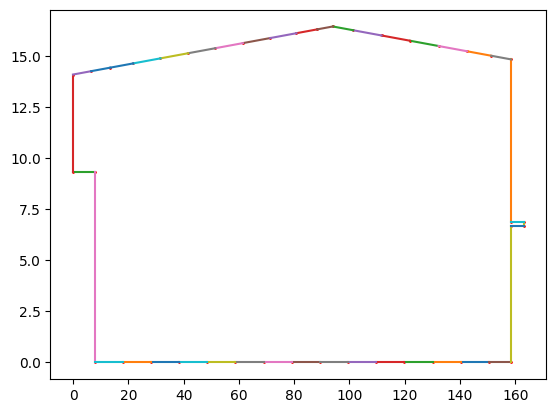

In [15]:
# TODO
import numpy as np
import matplotlib.pyplot as plt

# outline_points = np.fromfile("./output/pressure/p7_xm.outline")
# outline_points = outline_points.reshape((len(outline_points)//3 , 3))

polyline_points = np.fromfile("./output/pressure/p7_xm.polyline")
polyline_points = polyline_points.reshape((len(polyline_points)//3 , 3))

edges = np.fromfile("./output/pressure/p7_xm.polyline_edges", dtype=np.uint32)
edges = edges.reshape((len(edges)//2 , 2))
# edges.shape, polyline_points.shape
for e in edges:
    plt.plot(polyline_points[e][:,1], polyline_points[e][:,2])

# plt.scatter(outline_points[:,1], outline_points[:,2], c="blue", marker="x")
plt.scatter(polyline_points[:,1], polyline_points[:,2], c="red", s=1)
plt.show()